In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk
import re
import string
import contractions
import collections
from time import time
import matplotlib.pyplot as plt

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [6]:
import utils as u

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

### Dataset is a portion of the Tweets surrounding past storms

In [8]:
# df_full = pd.read_csv('ORIGINAL_LABELED/all_hurricanes_tweets_train.csv')
# df_full = pd.read_csv('YEARS_PRIOR_LABELED/test_with_labels.csv')
df_full = pd.read_csv('https://raw.githubusercontent.com/Cameron-Grams/Team-HIT-workspace/main/hurricane/test_with_labels.csv')

In [9]:
df_full.shape

(17577, 26)

In [10]:
df = df_full[df_full['class_label'] == 'other_relevant_information']
df.shape

(12813, 26)

## Process Text

In [11]:
X_raw_text = df['text'].apply(lambda x: u.preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))

In [12]:
# the min and max parameters will have to be adjusted

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(X_raw_text)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.141 s
n_samples: 12813, n_features: 3394


### Dimensionality reduction with SVD

# QUESTION QUESTION QUESTION

In [13]:
# decide on the number of components to use for SVD
n_comp = int(input("Enter components: "))

Enter components: 100


In [14]:
# decision on what level of components to truncate to... example = 100
# greater explained variance with higher numbers 

lsa = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.449 s
Explained variance of the SVD step: 25.5%


## Model selection

In [15]:
make_km = lambda x: KMeans(
    n_clusters=x,
    max_iter=100,
    init = 'k-means++',
    n_init=5,
)

In [16]:
Sum_of_squared_distances = []

K = range(1,15)

for k in K:
    km = make_km(k)
    km = km.fit(X_lsa)
    Sum_of_squared_distances.append(km.inertia_)

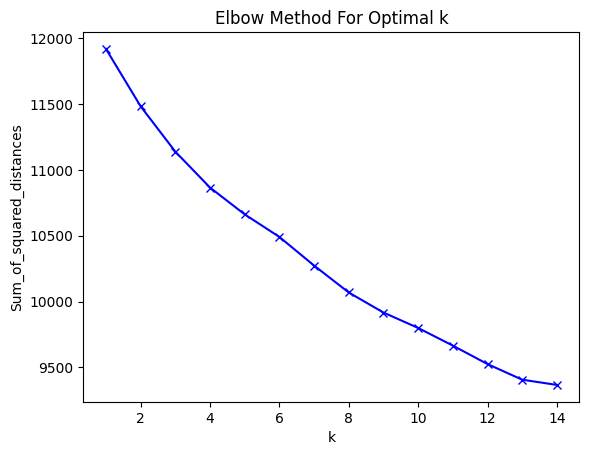

In [17]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Identify Clusters

In [18]:
# input the number of the elbow from the graph
num_k = int(input('>>>'))

>>>5


In [19]:
kmeans = make_km(num_k)
kmeans.fit(X_lsa)

KMeans(max_iter=100, n_clusters=5, n_init=5)

In [20]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print("\n")

Cluster 0: httpt sandi rt new arthur victim cleanup debri storm hit canada york amp recoveri southeast cristob island photo surviv video 

Cluster 1: storm tropic httpst rt httpt arthur form becom discus forecast center issu atlant track wind nation weather updat expect rain 

Cluster 2: garbag peopl httpst thi rt road realdonaldtrump clean water plea piec tweet know time cnn amp trump way area team 

Cluster 3: rt debri hurricane like amp peopl hit garbage cleanup make florida thi time come trump year rain water today know 

Cluster 4: httpst rt florenc cleanup debri florida michael ian new storm advisori dorian center categori season forecast coast ida latest flood 



##### 

In [21]:
preds = kmeans.predict(X_lsa)

In [22]:
df['predicted_subclass'] = preds

/tmp/ipykernel_11826/1108154002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_subclass'] = preds


In [23]:
# df_0 = df[df['predicted_subclass'] == 0]
# df_0.shape

In [24]:
# df_1 = df[df['predicted_subclass'] == 1]
# df_1.shape

In [25]:
# df_2 = df[df['predicted_subclass'] == 2]
# df_2.shape

In [26]:
# df_3 = df[df['predicted_subclass'] == 3]
# df_3.shape

In [27]:
# df_4 = df[df['predicted_subclass'] == 4]
# df_4.shape

In [28]:
# list(df_0['text'].sample(10))

In [29]:
other_cat_key = {
    0: 'personal_commentary',
    1: 'hurricane_facts',
    2: 'people_and_garbage',
    3: 'personal_interest',
    4: 'storm_location' 
}

In [30]:
df['class_label'] = df.apply(lambda x: other_cat_key[x['predicted_subclass']], axis=1)
df.shape

/tmp/ipykernel_11826/938979681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_label'] = df.apply(lambda x: other_cat_key[x['predicted_subclass']], axis=1)


(12813, 27)

In [36]:
#list(df.columns)

In [32]:
df_original = df_full[df_full['class_label'] != 'other_relevant_information']
df_original.shape

(4764, 26)

In [33]:
df_final = pd.concat([df, df_original])
df_final.shape

(17577, 27)

In [34]:
df_final = df_final.iloc[:, 2:]

In [35]:
df_final.sample(3)

,id,text,author_id,created_at,public_metrics,reply_settings,entities,possibly_sensitive,edit_history_tweet_ids,source,...,withheld,predictions,hurricane,fatalities,damage(billion USD),date,norm_date,pre_processed,class_label,predicted_subclass
4196,1169127251125985286,RT @yahoophoto: A handout photo made available...,2.388516e+07,2019-09-04T05:57:12.000Z,"{'retweet_count': 39, 'reply_count': 0, 'like_...",everyone,"{'annotations': [{'start': 50, 'end': 53, 'pro...",False,['1169127251125985286'],Twitter for iPhone,...,NaN,1,barry,1,0.60,2019-09-04 05:57:12+00:00,92.022737,rt yahoophoto a handout photo made avail nasa ...,personal_interest,3.0
6186,1041898797050290181,RT @OCREdge: @wellsfargo over an hour a half i...,9.899650e+17,2018-09-18T03:56:45.000Z,"{'retweet_count': 6, 'reply_count': 0, 'like_c...",everyone,"{'mentions': [{'start': 3, 'end': 11, 'usernam...",False,['1041898797050290181'],Twitter for Android,...,NaN,1,florence,53,24.23,2018-09-18 03:56:45+00:00,54.062291,rt ocredg wellsfargo hour half call hurrican a...,personal_interest,3.0
2728,1147368820065165312,"Blizzard of 96, Hurricane Sandy, a earthquake ...",2.232622e+08,2019-07-06T04:56:58.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,"{'urls': [{'start': 112, 'end': 135, 'url': 'h...",False,['1147368820065165312'],Twitter for iPhone,...,NaN,1,barry,1,0.60,2019-07-06 04:56:58+00:00,21.084490,blizzard 96 hurrican sandi earthquak japan eat...,storm_location,4.0


In [37]:
df_final.to_csv('expanded_other_17577samples.csv', index=False)